# Final project machine learning for NLP

## Overview of the project

Now that you're sort of acquainted with the IMDb database, we'll stick to it and build various flavors of text classification models with machine learning approaches. You will be able to compare these approaches to the vector space model with tf-idf weighting that we played with in lecture 2.

The project pursues two goals: 
1. better understand transformers and pre-trained large language models
2. get familiar with the (keras) implementation of various machine learning approaches for text classification

Extension to tagging tasks is rather straightforward once you've mastered text classification. We won't consider tagging as part of the project but if you're interesting in going further, I'm providing a step-by-step guided labwork (text only, no noteboook) to design a LSTM-based tagger in keras. It also features basic approaches to text classification and details on how to manipulate tensorflow datasets. You can  of course get inspired from this labwork in implementing your project.

## Content of the project

The project's notebook (this one!) has already a number of things coded for you to get started and instructions of what to do (and sometimes hints on how to do it) in the corresponding cells. We will go throught the following steps:

1. Play with BERT tokenizer
  - get acquainted with BERT's word piece tokenizer (instructions provided below)
  - load IMDb data and tokenize the sequences (with padding)

2. Play with BERT embeddings
  - get acquainted with the output of a BERT encoder (instructions provided below)
  - choose a few tokens that appear several times in the data
  - visualize (with t-SNE) their embeddings at the input, at the output and in one of the middle layer
  - visualize utterance embeddings (differentiating classes) -- [CLS] token, pooler, average word embedding

3. Develop a basic classification model
  - each utterance is represented as a single embedding (choose one of the above)
  - build a feed-forward classifier on top (hints on how to do that with keras below)

4. LSTM classifiction (using BERT's tokenizer)
  - each utterance is represented as a fixed-length sequence of token IDs
  - build a LSTM classifier on top of it (adapt the LM example from lecture 3)

5. BERT fine-tuning
  - each utterance is represented as a fixed-length sequence of token IDs (plus attention masks and token type IDs)
  - fine-tune a BERT encoder with a classification head (same as in 3 but the BERT encoder is also (re)trained)
  
## A few general hints

- We will make simple use of keras interfaces for training and not bother with tensorflow datasets and the likes. This means we will pass on arrays to model.fit(), leaving batching to the fit() function. As a consequence, you will need to shuffle the dataset that comes with all positive examples followed by all negative examples. Here's an easy way to shuffle elements in a list:

        buf = np.arrange(100)
        p = np.random.permutation(len(buf))
        buf = buf[p]

- Currently, the data you have is not divided into train, validation and test set: you will thus have to split the data in a 60/20/20 proportion, keeping in mind that the classes in each subset must be balanced (same number of samples).

- We will represent the class as a single integer, 0 for negative comments and 1 for positive comments. Hence the text classification task boils down to predicting a single value, either 0 or 1. The loss function corresponding to such a setting is the binary crossentropy (keras.losses.BinaryCrossentropy() or simply loss='binary_crossentropy'). The sparse categorical crossentropy can also be used (and should theoretically be equivalent in this case). As a performance metric to monitor training on the validation set, you can use accuracy or BinaryAccuracy().

- Training LSTMs and fine-tuning BERT becomes computationnaly expensive on CPU: it's thus better ot use a GPU. If you have CUDA installed on your machine, this should be transparent and tensorflow/keras should directly make use of the GPU. You can also go to Google Colaboratory (or any other similar framework): in this case, be aware that you're data (including trained models) will be lost when the session ends unless you save them elsewhere (e.g., in a drive or something like this).

## Project report

I am expecting you to hand over a report of your project which will take the form of a commented notebook. I'm not so much interested about the coding quality and rather concentrate on your intepretation of what you do and why you do it one way or the other. I'm thus expecting a notebook with a (huge) lot of comments! For instance, I want you to briefly reexplain what the models are doing from a theoretical point of view for step 3, 4 and 5 before running the implementation (concretely, briefly reexplain what we saw in the classroom). I also want you to comment the results and analyze a few examples that were misclasified, trying to figure out why and, if possible, relate this to the limits of the classification method used. I'm also expecting thoughts on how things could be improved. Don't expect me to simply run your notebook and check that it works: in most cases, I will not even try to run things and simply look at the comments and analyses you will provide.


In [1]:
import json
import numpy as np
from transformers import BertTokenizer
from transformers import TFBertModel
import tensorflow as tf
import keras
import keras.layers as layers
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

2024-01-11 19:45:42.623048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:45:42.623104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:45:42.623144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 19:45:42.631067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices('GPU')

2024-01-11 19:45:47.881150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:45:47.886345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:45:47.886476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Play with BERT tokenizer and embeddings

We will load a pre-trained MLM BERT model and the corresponding tokenizer. This is done by specifying a _checkpoint_ that designates the model to load from the Huggingface library of models. Note that there are many variants of BERT models to play with: see Huggingface models.

In [3]:
#
# Let's load a standard BERT model along with the corresponding tokenizer
# from the Huggingface library. Note that the tokenizer and model can be 
# loaded directly in Keras with tensorflow_hub without resorting to HugginfFace
# library. But we'll go the simple way here.
#

checkpoint = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(checkpoint)
encoder = TFBertModel.from_pretrained(checkpoint, output_hidden_states=True)

encoder.summary()
plot_model(encoder)

2024-01-11 19:45:53.193554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:45:53.193847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:45:53.193963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [4]:
#
# Let's first play with the tokenizer to see what it does and looks like
#

inputs = tokenizer("This is a test sentence to run through a transformer.", return_tensors="tf")

print(inputs)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(len(tokens), tokens)

# The tokenizer outputs three things:
#   - list of token ids as a result of the tokenization
#   - attention mask to tell whether attention should consider this token or not (because of padding)
#   - token type to separate multiple utterances in the case of multiple input
#
# The two functions convert_ids_to_tokens() and decode() are useful to see what's going on behind 
# the scene.


#
# We can also pass on a pair of utterances to encode them into a single sequence: they are
# separated by the special [SEP] token and the token_type attribute enables attributing tokens
# to one utterance or the other.
#
print('\n-----\n')
inputs = tokenizer("This is a first sentence.", "Followed by a second.", return_tensors="tf")

print(inputs)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(len(tokens), tokens)

#
# Another use of the tokenizer is to encore multiple utterances, possibly with padding as
# below. Note in this case the attention_mask attribute for the shortest sentence that
# tells (self-)attention should disregard the padding tokens. 
#
# Q: Any idea why we need attention masks, or, said differently, why we shouldn't have attention
# on the padding tokens?
# A: We apply masks to the source data because the padding sequences receive values after the 
# embedding layer. Now we prevent that the model learns from these padding sequences. The model will 
# not pay attention to these tokens and are thereby masked out from the model.
#
print('\n-----\n')
texts = ["This is a sentence longer than the second one.", "Followed by a second."]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

print(inputs)
for i in range(len(inputs['input_ids'])):
    buf = tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])
    print(len(buf), buf)


{'input_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=
array([[  101,  1188,  1110,   170,  2774,  5650,  1106,  1576,  1194,
          170, 11303,  1200,   119,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
14 ['[CLS]', 'This', 'is', 'a', 'test', 'sentence', 'to', 'run', 'through', 'a', 'transform', '##er', '.', '[SEP]']

-----

{'input_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=
array([[  101,  1188,  1110,   170,  1148,  5650,   119,   102, 19253,
         1174,  1118,   170,  1248,   119,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1,

In [5]:
outputs = encoder(inputs)

print(outputs.keys())
print('Contextual embedding for inputs in last_hidden_state with shape', outputs['last_hidden_state'].shape)
print('All embeddings in hidden_states with', len(outputs['hidden_states']), 'layers')

#
# The contextual embedding that comes out of the encoder can be found in
# outputs['last_hidden_state']: this is taken before the classification head (if any) and 
# contains the contextual representations of each input token after going through all the
# transformer blocks.
#
# We can access the intermediate representations at input and after each transformer block
# through outputs['hidden_states']: this is a list that contains the contextual representations
# of each token at the input (outputs['hidden_states'][0]) and after each of the 12 layers.
# After the 12th layer, outputs['hidden_states'][-1] is thus the same as outputs['hidden_states']
# which we can easily verify:
#

print(outputs['last_hidden_state'][0][0][:20])
print(outputs['hidden_states'][-1][0][0][:20])

#
# The pooler_output argument is a sentence embedding corresponding to the last layer 
# hidden-state of the first token of the sequence further processed by a linear layer
# and a Tanh activation function with weights trained for the next sentence prediction
# task -- see https://github.com/huggingface/transformers/issues/7540.
#

print(outputs[0])

#
# Q: What is the dimension of the output token embedding space?
# A: Each token has a embedding dimension of 768. Therefore, the output shape of the hidden states 
# are (number of documents or batch size, sequence length, separations [thus 2], number of transformer 
# layers, embedding size)
#

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
Contextual embedding for inputs in last_hidden_state with shape (2, 12, 768)
All embeddings in hidden_states with 13 layers
tf.Tensor(
[ 0.2579349  -0.03707325  0.09275724 -0.13268813  0.14971319  0.04284823
  0.06445578 -0.34800464  0.09467784 -1.1303685  -0.42358017  0.10616668
 -0.12024407  0.22460867 -0.5900551  -0.1240796   0.39927554  0.01370173
 -0.24529356 -0.3287855 ], shape=(20,), dtype=float32)
tf.Tensor(
[ 0.2579349  -0.03707325  0.09275724 -0.13268813  0.14971319  0.04284823
  0.06445578 -0.34800464  0.09467784 -1.1303685  -0.42358017  0.10616668
 -0.12024407  0.22460867 -0.5900551  -0.1240796   0.39927554  0.01370173
 -0.24529356 -0.3287855 ], shape=(20,), dtype=float32)
tf.Tensor(
[[[ 0.2579349  -0.03707325  0.09275724 ... -0.1122924   0.28411162
    0.06219836]
  [ 0.36840716 -0.2987729   0.8838848  ...  0.06753986  0.29090187
    0.12879556]
  [ 0.28687045  0.13657734  0.46283755 ...  0.453744    0.214

In [6]:
#
# Load IMDb data and process a small number of samples to play with. You will play later on with the full
# dataset for training. Here, we just want to play a bit with the embeddings.
#

fn = '../imdb-trn.json'

with open(fn, 'rt') as f:
    imdb_data = json.load(f)
    
small = imdb_data[:2000] + imdb_data[-2000:]

print(len(small))
print(small[0])
print(small[-1])

#
# We will now process the data with the tokenizer and create the labels
#

X = tokenizer([x[1] for x in small], return_tensors="tf", padding=True, truncation=True)
y = [1 if x[0] == 'pos' else 0 for x in small]

print('First sample after tokenization')
print('intput_ids =', tokenizer.convert_ids_to_tokens(X['input_ids'][0]))
print('label =', y[0])

print('\nLast sample after tokenization')
print('intput_ids =', tokenizer.convert_ids_to_tokens(X['input_ids'][-1]))
print('label =', y[-1])

4000
['pos', 'For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.']
['neg', 'Not that I dislike childrens movies, but this was a tearjerker with few redeeming qualities. M.J. Fox was the perfect voice for Stuart and the rest of the talent was wasted. Hugh Laurie can be amazingly funny, but is not given the chance in this movie. It´s sugar-coated sugar and would hardly appeal to anyone over 7 years of age. See Toy Story, Monsters Inc. or Shrek instead. 3/10']
First sample after tokenization
intput_ids = ['[CLS]', 'For', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', 'memorable', 'quotes', 'listed', 'for', 'this', 'g', '##em', '.', 'Imagine', 'a', 'movie', 'where', 'Joe', 'Pi', '##sco', '##po', 'is', 'actually', 'funn

In [7]:
#
# You're turn to play now that we have tokenized data and know how to run them through a BERT model to get 
# the tokens' embeddings. What we want to do first is visualize the embedding space as we did in lecture 1: 
# the difference is that we will do it on a token per token basis rather than globally for all tokens. So
# what you have to do here is:
#   - make a list of tokens that appear in the data (excluding padding) along with the number of times they appear
#   - choose a token that appears several times (typically between 50 and 100)
#   - retrieve the embeddings of each occurrence of this token in the data, at the entrance of the encoder (layer 0) and at the output
#   - make a t-SNE visualization of the token embeddings for the entrance embeddings and for the output embeddings
#
# Remember that the adequate distance between two embeddings is the cosine similarity. You can get inspiration from
# the notebook we used in lecture 1 to visualize word2vec embeddings.
#
# Q: Comment the results and the impact of BERT embedding. If we were to take word2vec embeddings, how many points
# would we have in the embedded space for the token.
#
from collections import Counter
from concurrent.futures import ProcessPoolExecutor
import numpy as np

# Function to convert IDs to tokens and count them
def count_tokens(batch):
    counter = Counter()
    for input_id in batch:
        tokens = tokenizer.convert_ids_to_tokens(input_id)
        counter.update(tokens)
    return counter

# Function to merge two counters
def reduce_counters(counter1, counter2):
    counter1.update(counter2)
    return counter1

def parallelize_token_counting(input_ids, num_splits=4):
    # Split the input_ids into chunks for parallel processing
    chunks = np.array_split(input_ids, num_splits)
    
    token_counter = Counter()
    with ProcessPoolExecutor() as executor:
        # Map the count_tokens function to each chunk in parallel
        futures = [executor.submit(count_tokens, chunk) for chunk in chunks]
        
        # Reduce the results as they come in
        for future in futures:
            token_counter = reduce_counters(token_counter, future.result())
            
    return token_counter

token_count = parallelize_token_counting(X['input_ids'], num_splits=8)
token_count.most_common(5)

## Slow version
# from collections import Counter
# token_counter = Counter()

# n_inputs = len(y)
# n_tokens = n_inputs * 512

# for input_id in X['input_ids']:
#     token_counter.update(Counter(tokenizer.convert_ids_to_tokens(input_id)))
#     print(f"\rCounting occurences of the tokens: {token_counter.total()}/{n_tokens}", end="")

# print()

[('[PAD]', 922616), ('.', 46562), ('the', 40294), (',', 37392), ('a', 22686)]

In [8]:
high_low_freq_filtered_tokens = list(filter(lambda word: token_count[word] < 100 and token_count[word] > 50, token_count))

In [9]:
import random
randomly_selected_token = random.choice(list(high_low_freq_filtered_tokens))
randomly_selected_token_input_id = tokenizer(randomly_selected_token, return_tensors="tf")['input_ids'][0, 1]
indices_for_random_token = tf.where(X['input_ids'] == randomly_selected_token_input_id)
randomly_selected_token, randomly_selected_token_input_id, len(indices_for_random_token)

('direct', <tf.Tensor: shape=(), dtype=int32, numpy=2904>, 53)

In [9]:
import gc
def batch_generator(X, batch_size, indices=None):
    """Generator to yield batches of input data and indices."""
    n_samples = X['input_ids'].shape[0]
    for start_idx in range(0, n_samples, batch_size):
        end_idx = start_idx + batch_size
        batch_X = {key: value[start_idx:end_idx] for key, value in X.items()}
        batch_indices = None
        if indices is not None:
            # Create a mask for the current batch
            mask = (indices[:, 0] >= start_idx) & (indices[:, 0] < end_idx)
            # Apply the mask and adjust indices to local batch coordinates
            batch_indices = tf.boolean_mask(indices, mask)
            batch_indices = batch_indices - [start_idx, 0]
        yield batch_X, batch_indices


def filter_data(X, indices):
    # Convert indices to numpy array for manipulation
    indices_np = indices.numpy()

    # Filter out the unique batch indices
    unique_batches = np.unique(indices_np[:, 0])

    # Filter X based on unique batch indices
    filtered_X = {key: tf.gather(value, unique_batches) for key, value in X.items()}

    # Adjust indices to the new filtered_X
    adjusted_indices_np = indices_np.copy()
    for i, batch_idx in enumerate(unique_batches):
        adjusted_indices_np[indices_np[:, 0] == batch_idx, 0] = i

    # Convert adjusted indices back to TensorFlow tensor if needed
    adjusted_indices = tf.convert_to_tensor(adjusted_indices_np, dtype=tf.int64)

    return filtered_X, adjusted_indices

def get_embeddings_in_batches(model, X, batch_size, indices=None, return_types=None):
    gc.collect()

    # Initialize a dictionary to hold embeddings based on the requested return types
    return_types = ['last'] if None else return_types
    all_embeddings = {return_type: [] for return_type in return_types}

    # Adjust indices if provided
    if indices is not None:
        X, indices = filter_data(X, indices)

    # Process each batch
    for batch_X, batch_indices in batch_generator(X, batch_size, indices):
        outputs = model(batch_X)

        # Extract and gather embeddings for each specified return type
        for return_type in return_types:
            if return_type == 'first':
                embedding_key = 'hidden_states'
                embedding_index = 0
            elif return_type == 'last':
                embedding_key = 'last_hidden_state'
                embedding_index = None
            elif return_type == 'pool':
                embedding_key = 'pooler_output'
                embedding_index = None
            else:
                raise ValueError(f"Unsupported return type: {return_type}")

            embeddings = outputs[embedding_key]

            # Extract the embeddings
            if embedding_index is not None:
                embeddings = embeddings[embedding_index]

            # If indices are provided, gather only the relevant embeddings
            if batch_indices is not None and return_type != 'pool':
                embeddings = tf.gather_nd(embeddings, batch_indices)

            # Store the gathered embeddings
            all_embeddings[return_type].append(embeddings)

    # Concatenate results for each embedding type
    concatenated_results = {return_type: tf.concat(embeddings_list, axis=0) for return_type, embeddings_list in all_embeddings.items()}

    # Return a tuple of the requested embedding types
    return tuple(concatenated_results[return_type] for return_type in return_types)


In [11]:
batch_size = 8
specific_embeddings, specific_last_hidden_states = get_embeddings_in_batches(encoder, X, batch_size, indices_for_random_token, return_types=['first', 'last'])
specific_embeddings, specific_last_hidden_states = specific_embeddings.numpy(), specific_last_hidden_states.numpy()
specific_embeddings, specific_last_hidden_states

(array([[-4.7235215e-01,  1.8289989e+00,  2.8034575e-02, ...,
          1.1175582e+00,  5.7388335e-01,  2.6354393e-01],
        [-2.8177741e-01,  1.2405366e+00,  4.4418520e-01, ...,
          1.3946362e+00,  1.0609273e+00,  8.0450195e-01],
        [-1.0944700e-01,  1.4945166e+00,  1.4598244e-01, ...,
          9.2549556e-01,  5.5344272e-01,  5.6598896e-01],
        ...,
        [ 1.5812391e-01,  1.4445614e+00,  2.6160190e-01, ...,
          1.4589529e+00,  8.0283916e-01,  6.9390374e-01],
        [-5.7777762e-04,  1.1726050e+00,  3.2212305e-01, ...,
          1.3629360e+00,  9.2470801e-01,  7.1967489e-01],
        [-1.9518024e-01,  1.9220393e+00, -1.8120751e-02, ...,
          9.9303937e-01,  6.8109018e-01,  3.7546185e-01]], dtype=float32),
 array([[-0.06241042, -0.31558   , -0.45479578, ...,  1.2653413 ,
          0.77186817,  0.23573036],
        [ 0.15233938, -0.05535804,  0.05064019, ...,  0.44791776,
          0.8072146 ,  1.0088435 ],
        [ 0.14388907,  0.24950375, -0.41905642

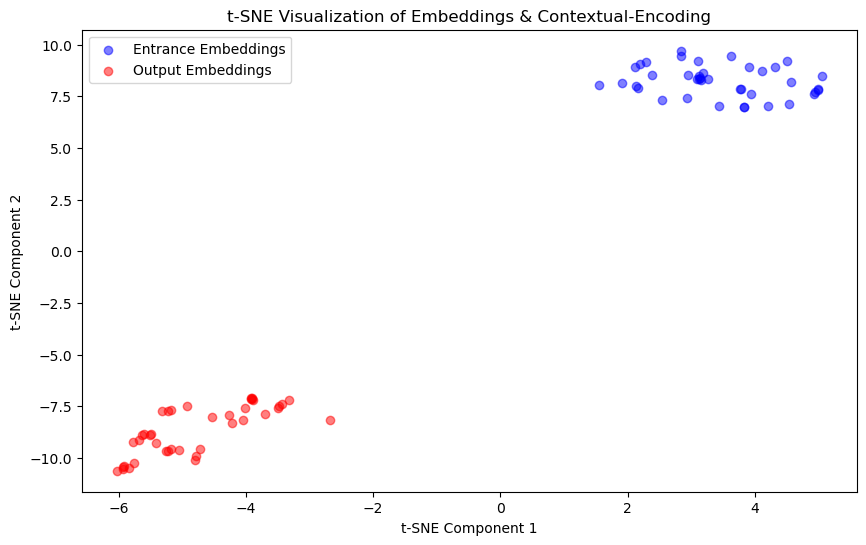

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_encodings = tf.concat([specific_embeddings, specific_last_hidden_states], axis=0)

Y_encodings = TSNE(n_components=2, metric='cosine', init='random', random_state=0, method='exact').fit_transform(X_encodings)

n = specific_embeddings.shape[0]  # Number of embeddings (should be same for entrance and output)
entrance_embeddings_tsne = Y_encodings[:n, :]
output_embeddings_tsne = Y_encodings[n:, :]

plt.figure(figsize=(10, 6))


# Plot entrance embeddings
plt.scatter(entrance_embeddings_tsne[:, 0], entrance_embeddings_tsne[:, 1], c='blue', label='Entrance Embeddings', alpha=0.5)

# Plot output embeddings
plt.scatter(output_embeddings_tsne[:, 0], output_embeddings_tsne[:, 1], c='red', label='Output Embeddings', alpha=0.5)
# Add a legend
plt.legend()

plt.title('t-SNE Visualization of Embeddings & Contextual-Encoding')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

The t-SNE visualization of token embeddings from a BERT model shows these key findings:

1. **Transformation In Layers**: The embeddings at the input layer are closer together, in contrast to the output where they are are more spread out. It indicates that BERT integrates contextual information significantly.

2. **BERT vs. Word2Vec**: Unlike Word2Vec's single embedding per token, BERT provides multiple context-dependent embeddings for the same token, as shown by the presence of multiple points for a single token in the visualization.

In [13]:
#
# The encoder provides two (direct) ways to embed utterances: in practice, we often use the embedding of the
# [CLS] token as an embedding of the utterance; one can also use the pooler_output attribute of the encoder 
# which corresponds to a projection of the [CLS] token embedding through a feed-forward layer trained for the
# next sentence prediction objective of BERT training. Note that some folks also consider the average of the 
# token embeddings taken at the last layer (a strategy known as _average pooling_), which we will not consider
# here.
#
# Following the same idea as for token embeddings, we want to visualize with t-SNE the properties of these two 
# main document embedding strategies and see how well (or not) the two classes are separated. As for token
# embeddings, the cosine similarity distance is an appropriate way to compare utterance embeddings.
#
# What you need to do is thus:
#   - an array where each line is an utterance embedding (either [CLS] or pooler_output)
#   - t-SNE plot of the rows of the array, differentiating positive and negative examples
#
# Q: Comment the results. Are the two classes easily separable for those two representations? Is one 
# representation apparently better than the other? And why according to you? Do you think a vector space model
# with tf-idf representation be better (no need to do the implementation unless you have time on your hand, 
# I'm rather interested in your intuition).
#



In [10]:
cls_token = '[CLS]'
cls_token_input_id = tokenizer(cls_token, return_tensors="tf")['input_ids'][0, 1]

indices_for_cls_token = tf.where(X['input_ids'] == cls_token_input_id)

cls_token, cls_token_input_id, len(indices_for_cls_token)

('[CLS]', <tf.Tensor: shape=(), dtype=int32, numpy=101>, 4000)

In [15]:
gc.collect()

4063

In [1]:
batch_size = 16
cls_embeddings, pooler_embeddings = get_embeddings_in_batches(encoder, X, batch_size, indices_for_cls_token, return_types=['last', 'pool'])
# cls_embeddings, pooler_embeddings = cls_embeddings.numpy(), pooler_embeddings.numpy() 


NameError: name 'get_embeddings_in_batches' is not defined

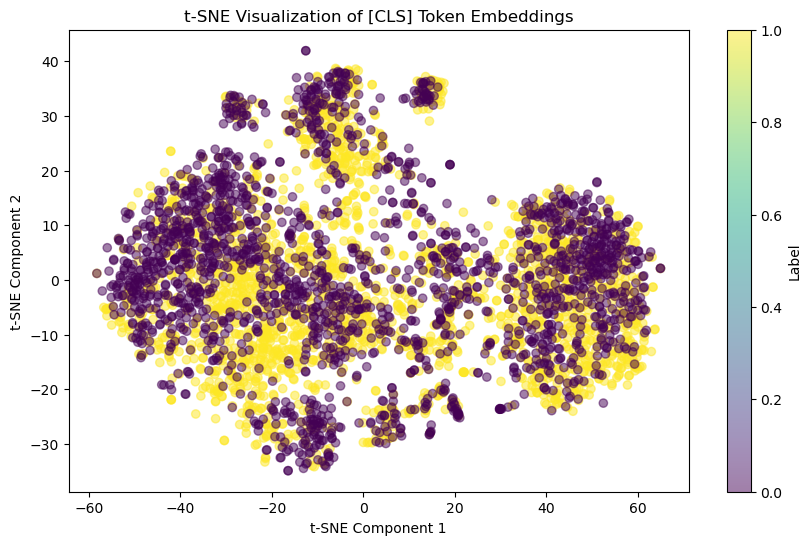

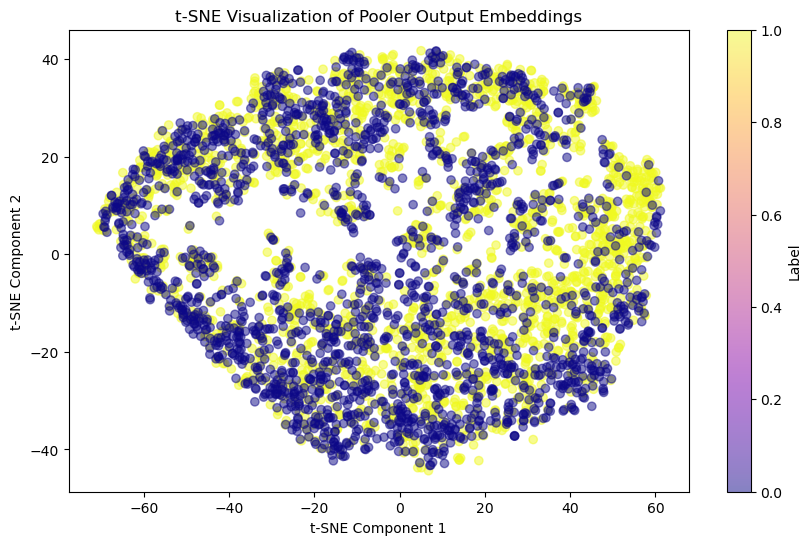

In [ ]:
X_encodings_cls = TSNE(n_components=2, metric='cosine', init='pca', random_state=0).fit_transform(cls_embeddings)
X_encodings_pooler = TSNE(n_components=2, metric='cosine', init='pca', random_state=0).fit_transform(pooler_embeddings)

# Plotting [CLS] Embeddings
plt.figure(figsize=(10, 6))
plt.scatter(X_encodings_cls[:, 0], X_encodings_cls[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Label')
plt.title('t-SNE Visualization of [CLS] Token Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Plotting Pooler Embeddings
plt.figure(figsize=(10, 6))
plt.scatter(X_encodings_pooler[:, 0], X_encodings_pooler[:, 1], c=y, cmap='plasma', alpha=0.5)
plt.colorbar(label='Label')
plt.title('t-SNE Visualization of Pooler Output Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

The t-SNE representation for both [CLS] and pooled embeddings from BERT show dispersed classes, with no clear separation between positive and negative reviews. Furthermore, the [CLS] token embeddings and the pooler outputs do not seem to outperform in class separability, suggesting that the BERT embeddings require additional processing to classify the review effectively. While TF-IDF lacks BERT's contextual awareness, it could offer better class separation if certain frequent words/tokens are solid indicators for sentiment.

## A basic feed-forward classifier on top of utterance embeddings

The first neural classifier that we will build is rather trivial: we will simply build a basic feed-forward classifier that takes as input either one of the utterance embeddings from the previous step and run two fully-connected layers towards the final decision.

Here are a few hints to help you with the construction of such a model in Keras. Building a model in keras follows a three step process:
1. define the model architecture
2. _compile_ the model with a loss function and an optimizer
3. _fit_ the model parameters on training data, monitoring the behavior of the model on validation data

You can get examples and more details in the labwork text that was provided.

### Define the model architecture

There are two main ways to define a keras model. The first one use a _sequential_ API where we define layers in a serial way, each layers being implicitely connected. For a two layer feed-forward network, that will look like

    idim = encoder.hidden_size
    dim1 = 256
    dim2 = 128
    odim = 1 # 1 if binary_crossentropy loss is used, number of classes if categorical_crossentropy or sparse_categorical_crossentropy is used

    model = Sequential()
    model.add(Dense(dim1, input_shape=(idim,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(dim2, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2), activation='softmax') # if we want a two dimensional output

The second option is known as the _functional_ API where the operations between layers is made explicit, the model being implicitely created from the sequence of operations that you define. Disregarding dropout, this would look like

    inputs = tf.keras.Input(shape=(idim,)) # an empty layer to materialize what the input will be
    x1 = tf.keras.layers.Dense(dim1, activation=tf.nn.relu)(inputs)
    x2 = tf.keras.layers.Dense(dim2, activation=tf.nn.relu)(x1)
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x2)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

### Compile the model

You have to specify a loss function that will measure how well the classifier predicts training data. There are two options here since we're considering a binary classification task with 0/1 labels:
- output prediction is a single activation value (either 0 or 1), in which case the appropriate loss function is the binary crossentropy
- output prediction is a two-valued vector with class probabilities, in which case the appropriate loss function is
the sparse categorical cross-entropy (assuming reference labels are 0/1 values -- if you want to use 1-hot encoding of the labels rather as in the labwork text example, categorical cross-entropy is your friend)

As for the optimizer, we will keep it very basic and simply use the Adam optimizer with default parameters in this case.

In its simplest form, this gives something like:

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    model.summary()

but much more complex variants can be used: see Keras documentation if you're interested.

### Fit the model

Assuming you have a numpy array X_train (or simply a list) with the input embeddings to train on (number of samples x input dimension) and the corresponding labels in a y_train vector (of 0s and 1s), fitting is a simple call to something like

    model.fit(X_train, y_train, batch_size=32, epochs=10)

You can specify validation data and metrics to report progress, e.g., 

    model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data = (X_val, y_val), metrics=['accuracy'])

You can alternately not specify validation data and simply ask fit() to reserve x% of the training data for validation with the argument validation_split = x/100. See the LSTM example of lecture 3 for instance.

### Precit or evaluate the model

You can use model.evaluate() or model.predict() to measure how well your model is doing on the test data. See accompanying labwork text for details.

In [1]:
# Load the entire IMDb dataset, separate test data and possibly validation data (your choice to use or not an
# explicit validation set) and prepare the X_train and y_train inputs for training, X_test and y_test for 
# evaluation (and possibly X_valid, y_valid) with either one of the utterance embeddings from the previous 
# question.
#
# Define a model, train it and evaluate it. You can play a bit with the parameters (dropout, dim1/dim2) and see
# where it takes us. How does that compare to what we did with the vector space model with tf-idf weights along
# with a k-nn classification?
#
# from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Dense, Dropout, Input
from transformers import TFBertModel, BertTokenizer


checkpoint = 'bert-base-cased'
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_model.trainable = False

idim = bert_model.config.hidden_size
max_len = bert_model.config.max_position_embeddings
dim1 = 256
dim2 = 128
odim = 1 # 1 if binary_crossentropy loss is used, number of classes if categorical_crossentropy or sparse_categorical_crossentropy is used

input_ids = Input(shape=(max_len,), dtype='int32', name='input_ids')
token_type_ids = Input(shape=(max_len,), dtype='int32', name='token_type_ids')
attention_mask = Input(shape=(max_len,), dtype='int32', name='attention_mask')

bert_output = bert_model({'input_ids': input_ids, 
                       'token_type_ids': token_type_ids, 
                       'attention_mask': attention_mask
                       })['pooler_output']

x1 = Dense(dim1, activation='relu')(bert_output)
d1 = Dropout(0.2)(x1)
x2 = Dense(dim2, activation='relu')(d1)
d2 = Dropout(0.2)(x2)
outputs = Dense(odim, activation='sigmoid')(d2)  # Use 'sigmoid' for binary classification

# Define the model
model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=outputs)
model.summary()

2024-01-12 14:27:59.311534: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 14:27:59.311602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 14:27:59.311645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 14:27:59.320583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 14:28:04.521496: I tensorflow/compiler/

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

In [2]:
import json
fn = '../imdb-trn.json'

with open(fn, 'rt') as f:
    imdb_data = json.load(f)
    
small = imdb_data[:2000] + imdb_data[-2000:]

import tensorflow as tf
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(small, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

tokenizer = BertTokenizer.from_pretrained(checkpoint)
X_train = tokenizer([x[1] for x in train_data], return_tensors="tf", padding=True, truncation=True)
X_train = {key: tf.convert_to_tensor(value) for key, value in X_train.items()}
y_train = tf.convert_to_tensor([1 if x[0] == 'pos' else 0 for x in train_data])

X_val = tokenizer([x[1] for x in val_data], return_tensors="tf", padding=True, truncation=True)
X_val = {key: tf.convert_to_tensor(value) for key, value in X_val.items()}
y_val = tf.convert_to_tensor([1 if x[0] == 'pos' else 0 for x in val_data])

X_test = tokenizer([x[1] for x in test_data], return_tensors="tf", padding=True, truncation=True)
X_test = {key: tf.convert_to_tensor(value) for key, value in X_test.items()}
y_test = tf.convert_to_tensor([1 if x[0] == 'pos' else 0 for x in test_data])


In [16]:
import tensorflow as tf

batch_size = 8

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_data=(X_val, y_val))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/5
300/300 [==============================] - 122s 388ms/step - loss: 0.6475 - accuracy: 0.6421 - val_loss: 0.6146 - val_accuracy: 0.6825
Epoch 2/5
300/300 [==============================] - 119s 398ms/step - loss: 0.6443 - accuracy: 0.6375 - val_loss: 0.5992 - val_accuracy: 0.7088
Epoch 3/5
300/300 [==============================] - 121s 404ms/step - loss: 0.6410 - accuracy: 0.6371 - val_loss: 0.6129 - val_accuracy: 0.6950
Epoch 4/5
300/300 [==============================] - 121s 404ms/step - loss: 0.6432 - accuracy: 0.6338 - val_loss: 0.5901 - val_accuracy: 0.7212
Epoch 5/5
25/25 [==============================] - 28s 1s/step - loss: 0.5803 - accuracy: 0.7225
Test Loss: 0.5802605748176575, Test Accuracy: 0.7225000262260437


## A recurrent classifier

The second classifier that we consider is a direct application of recurrent neural networks. It is similar to what we did for language modeling except that it takes as input a tokenized version of the utterance that might contain
padding to ensure all input sequences have the same length. We will directly use BERT's tokenizer with padding and adapt the small LM example we played with in lecture 3 to perform class prediction rather than next token prediction. The model features an embedding layer whose input size is the number of tokens in the tokenizer's vocabulary (which can be accessed through tokenizer.vocab_size or, if you prefer, simply going through your data to see who's present), a LSTM layer that processes the input sequence, one or several fully connected classification layers that takes as input the state of the last LSTM cell. Optimizer and loss are the same as for the feed-forward architecture.


In [3]:
#
# TODO
#
# With the above explanations, the example from lecture 3 on language generation with LSTM, a little inspiration 
# from the labwork text that accompanies the project, you should be able to define, train and evaluate a LSTM 
# model for text classification and compare it with we've done so far. You can play with the parameters (embedding 
# size, hidden dim in LSTM).
#
# If you feel like going further, you can try BiLSTM (simply replace LSTM layer by BiLSTM layer) and/or 
# hierarchical LSTMs. And if very very curious, replace the LSTM cell by a GRU one.
#
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained BERT model
checkpoint = 'bert-base-cased'
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_model.trainable = False  # Set BERT layers to non-trainable

idim = bert_model.config.hidden_size
max_len = bert_model.config.max_position_embeddings
lstm_units = 128  # Number of units in LSTM layer
dim1 = 256
dim2 = 128
odim = 1  # Output dimension for binary classification

# Define input layers
input_ids = Input(shape=(max_len,), dtype='int32', name='input_ids')
token_type_ids = Input(shape=(max_len,), dtype='int32', name='token_type_ids')
attention_mask = Input(shape=(max_len,), dtype='int32', name='attention_mask')

# Get BERT's output
bert_output = bert_model({'input_ids': input_ids, 
                          'token_type_ids': token_type_ids, 
                          'attention_mask': attention_mask
                          })[0]  # Use [0] to get last_hidden_state

# LSTM layer
lstm_layer = LSTM(lstm_units)(bert_output)

# Dense layers
x1 = Dense(dim1, activation='relu')(lstm_layer)
d1 = Dropout(0.2)(x1)
x2 = Dense(dim2, activation='relu')(d1)
d2 = Dropout(0.2)(x2)
outputs = Dense(odim, activation='sigmoid')(d2)

# Define the model
model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=outputs)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                            

In [4]:
batch_size = 8

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_data=(X_val, y_val))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/5


2024-01-12 14:28:28.428560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-12 14:28:28.756885: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe02c753d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 14:28:28.756924: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-12 14:28:28.761900: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-12 14:28:28.823047: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 94/300 [========>.....................] - ETA: 1:00 - loss: 0.6643 - accuracy: 0.5957

## Thre Graal: fine-tune a BERT model with a text classification head